## IMPORTING PACKAGES

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import graphviz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix

## PREPARING THE DATASETS

#### 0.Importing the Datasets

In [2]:
filename = "penguins.csv"
palmer_penguin = pd.read_csv(filename)
palmer_penguin.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Remove missing values

In [3]:
palmer_penguin = palmer_penguin.dropna(axis="index", how="any")
palmer_penguin.head()
print(len(palmer_penguin))

333


### 1.Setting Up the Training and Test Datasets

We will split the original dataset into 4 different splitting strategies, with the proportion of traning and test as follows: 40/60, 60/40, 80/20, and 90/10.

First, we split the original dataset into feature and label columns, as the target we are considering now is 


In [4]:
palmer_penguin_feature = palmer_penguin.drop(columns = ['species'])
palmer_penguin_label = palmer_penguin['species']

Then the feature and label are split into 4 splitting strategies as mentioned above.

In [5]:
training_sizes = {
    "40/60": 0.4,
    "60/40": 0.6,
    "80/20": 0.8,
    "90/10": 0.9,
}

datasets = {}
for name, training_size in training_sizes.items():
    feature_train, feature_test, label_train, label_test = train_test_split(
        palmer_penguin_feature, palmer_penguin_label,
        test_size=(1 - training_size),
        shuffle=True,
        stratify=palmer_penguin_label,
        random_state = 42
    )

    datasets[name] = (feature_train, feature_test, label_train, label_test)



#### Original Set

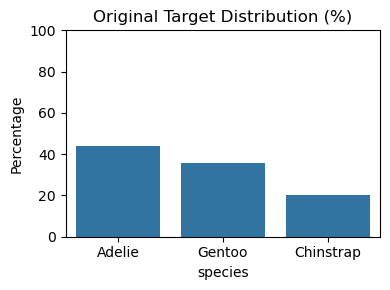

In [6]:

plt.figure(figsize=(4,3))
original_pct = palmer_penguin_label.value_counts(normalize=True) * 100
original_df = pd.DataFrame({
    'species': original_pct.index.astype(str),
    'Percentage': original_pct.values
})

sns.barplot(data=original_df, x='species', y='Percentage')
plt.title("Original Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("species")
plt.tight_layout()
plt.show()

#### Training Set

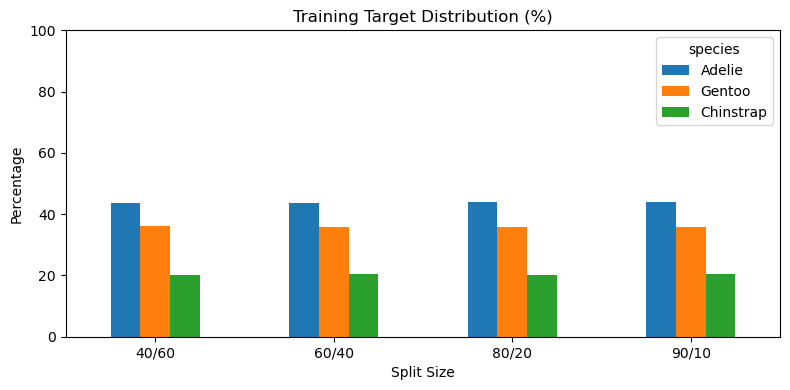

In [7]:
train_distributions = {}

for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    train_pct = label_train.value_counts(normalize=True) * 100
    train_distributions[name] = train_pct

train_df = pd.DataFrame(train_distributions).T

train_df.plot(kind='bar', figsize=(8, 4), legend=True)
plt.title("Training Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Split Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Test Set

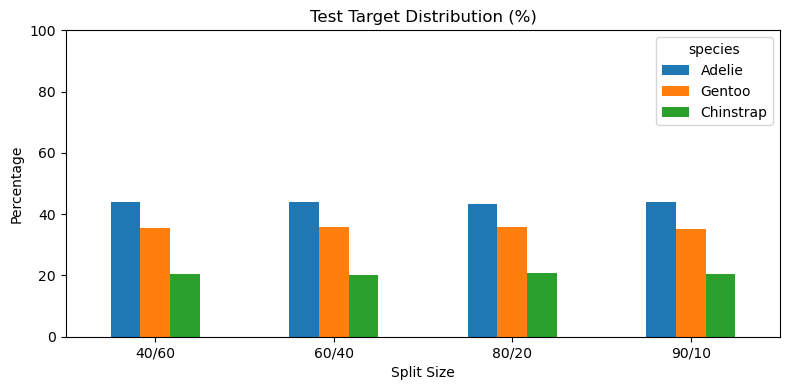

In [8]:
test_distributions = {}

for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    test_pct = label_test.value_counts(normalize=True) * 100
    test_distributions[name] = test_pct

test_df = pd.DataFrame(test_distributions).T

test_df.plot(kind='bar', figsize=(8, 4), legend=True)
plt.title("Test Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Split Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Categorical handling

In [9]:
import numpy as np
column_transformer = ColumnTransformer(
    transformers=[("categorical", OneHotEncoder(drop="first", sparse_output=False), ['island', 'sex'])],
    remainder="passthrough",
    verbose_feature_names_out=False  
)



label_order = ['Adelie', 'Gentoo', 'Chinstrap']  
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(label_order) 
for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    feature_train = column_transformer.fit_transform(feature_train)
    feature_test = column_transformer.transform(feature_test)

    label_train = label_encoder.fit_transform(label_train)
    label_test = label_encoder.transform(label_test)

    datasets[name] = (feature_train, feature_test, label_train, label_test)


### 2. Building the Decision Tree Classifiers

In [10]:
models = {}
for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    model = tree.DecisionTreeClassifier(criterion = "entropy", random_state=42)
    model.fit(feature_train, label_train)
    models[name] = model

graphs = {}

for name, model in models.items():
    dot_data = tree.export_graphviz(
        model, 
        out_file=None,
        filled=True,
        rounded=True,
    )
    graph = graphviz.Source(dot_data)
    graphs[name] = graph


Decision Tree Graph for 40/60 splitting.

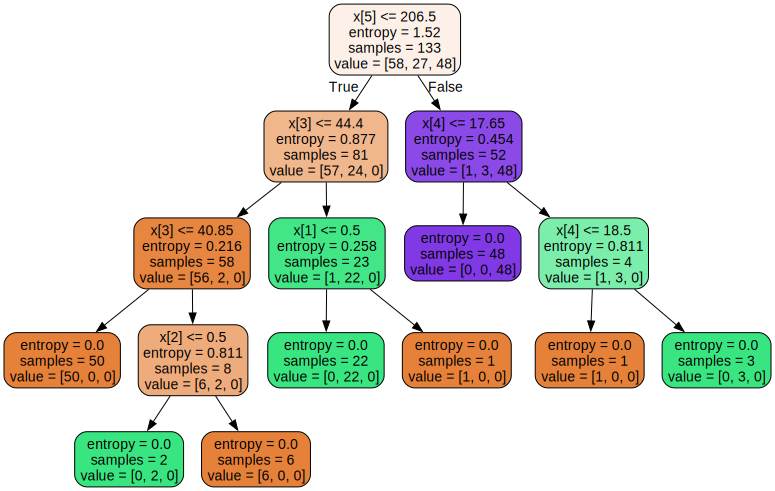

In [11]:
graphs['40/60']

Decision Tree Graph for 60/40 splitting.

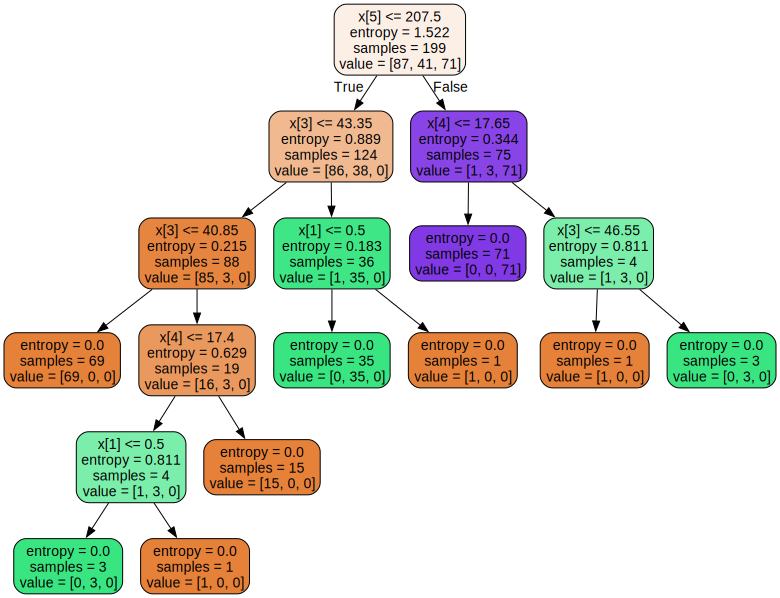

In [12]:
graphs['60/40']

Decision Tree Graph for 80/20 splitting.

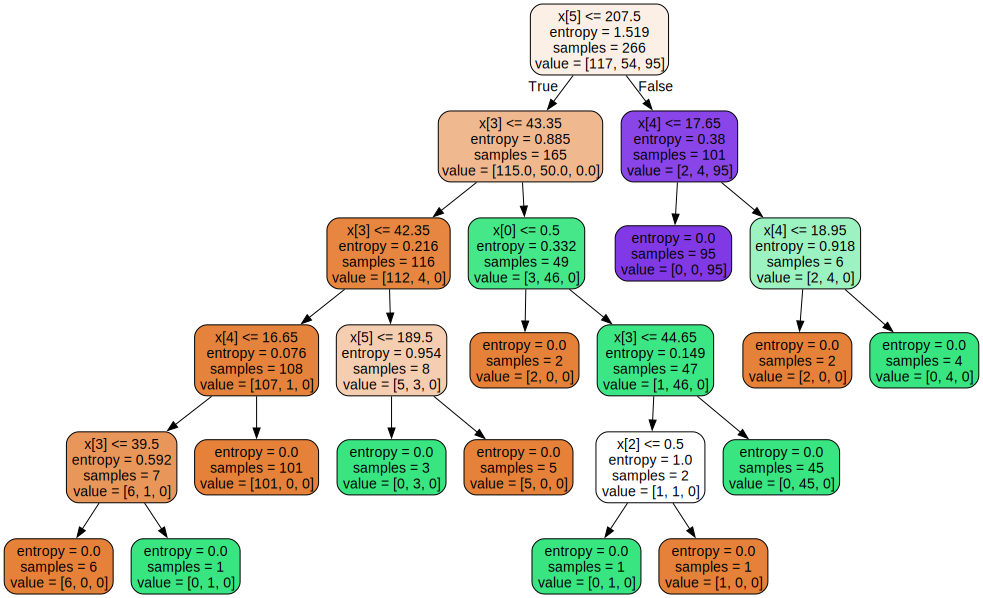

In [13]:
graphs['80/20']

Decision Tree Graph for 90/10 splitting.

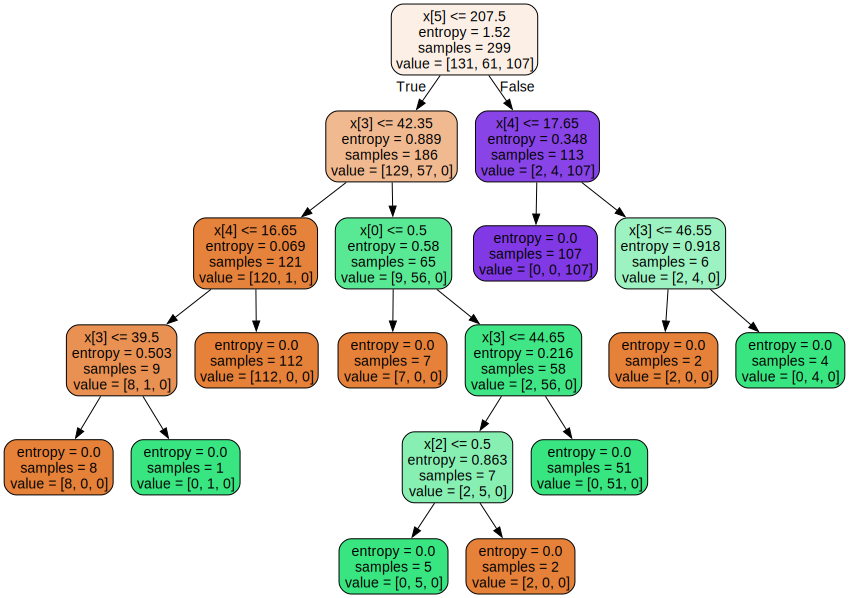

In [14]:
graphs["90/10"]

### 2. Evaluating the Decison Tree Classifiers

In [15]:

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
eval_results = {}
def evaluate_decision_tree_classifier(model, name):
    feature_train, feature_test, label_train, label_test = datasets[name]
    y_pred = model.predict(feature_test)
    y_true = label_test
    report = classification_report(y_true, y_pred, labels=[0,1,2], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df.round(2))

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    cm_display = ConfusionMatrixDisplay(cm, display_labels = label_encoder.classes_)
    cm_display.plot(cmap = "Blues")
    plt.title("Confusion matrix: " + name)
    plt.show()

    

#### a. 40/60 Splitting

,precision,recall,f1-score,support
0,1.00,0.94,0.97,88.00
1,0.87,1.00,0.93,41.00
2,1.00,0.99,0.99,71.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.96,0.98,0.97,200.00
weighted avg,0.97,0.97,0.97,200.00


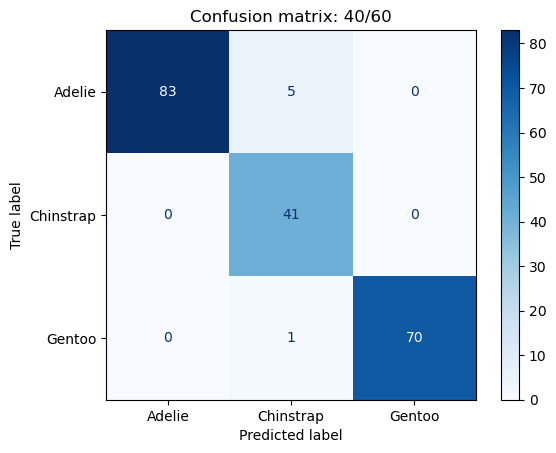

In [16]:
evaluate_decision_tree_classifier(models['40/60'],'40/60')

#### Evaluation and Insights:
**Classification Report:**

- `Adelie`: The model performs exceptionally well, with a **precision of 1.00** and **recall of 0.94**, resulting in a high **f1-score of 0.97**. With a support of 88 samples, this class is well represented and clearly learned by the model.

- `Chinstrap`: This class also performs decently, with **precision = 0.87** and **recall = 1.00**, yielding an **f1-score = 0.93**. With 41 samples, the model seems reasonably confident and consistent.

- `Gentoo`: The model performs exceptionally well for this class, achieving **precision = 1.00**, **recall = 0.99**, and **f1-score = 0.99**. With 71 samples, this class is well-represented in the dataset, contributing to the model's strong performance.

- **Accuracy**: The overall accuracy is 0.97, indicating that the model correctly predicts the class in the majority of cases.

- **Macro Average**: With **macro precision = 0.96**, **macro recall = 0.98**, and **macro f1-score = 0.97**, we see that the model performs well across all classes, treating each class equally regardless of size.

- **Weighted Average:** The **weighted precision, recall, and f1-score** are all **0.97**, closely matching accuracy. This shows that the model performs well on average, primarily due to good performance on all classes.

**Confusion Matrix:**

- Most predictions for `Adelie`, `Gentoo`, and `Chinstrap` are correct, showing that the model is highly confident in classifying these classes.

- There are very few false positives for any class, indicating strong precision across all classes.

- Overall, the confusion matrix confirms that the model handles all classes quite well, with minimal misclassifications.

#### b. 60/40 Splitting

,precision,recall,f1-score,support
0,1.00,0.97,0.98,59.00
1,0.87,1.00,0.93,27.00
2,1.00,0.96,0.98,48.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.96,0.97,0.96,134.00
weighted avg,0.97,0.97,0.97,134.00


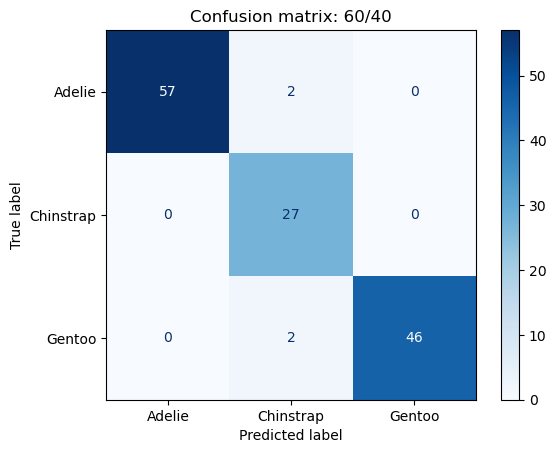

In [ ]:
evaluate_decision_tree_classifier(models['60/40'],'60/40')

**Classification Report:**

`Adelie`: The model performs exceptionally well, with a **precision of 1.00** and **recall of 0.97**, resulting in a **high f1-score of 0.98**. With a support of 59 samples, this class is well represented and clearly learned by the model.

`Chinstrap`: This class also performs decently, with **precision = 0.87** and **recall = 1.00**, yielding an **f1-score = 0.93**. With 27 samples, the model seems reasonably confident and consistent.

`Gentoo`: The model performs exceptionally well for this class, achieving **precision = 1.00**, **recall = 0.96**, and **f1-score = 0.98**. With 48 samples, this class is well-represented in the dataset, contributing to the model's strong performance.

**Accuracy**: The overall accuracy is **0.97**, indicating that the model correctly predicts the class in the majority of cases.

**Macro Average**: With macro **precision = 0.96**, **macro recall = 0.97**, and **macro f1-score = 0.96**, we see that the model performs well across all classes, treating each class equally regardless of size.

**Weighted Average:** The weighted precision, recall, and f1-score are all **0.97**, closely matching accuracy. This shows that the model performs well on average, primarily due to good performance on all classes.

**Confusion Matrix**:
-Most predictions for `Adelie`, `Gentoo`, and `Chinstrap` are correct, showing that the model is highly confident in classifying these classes.
-There are very few false positives for any class, indicating strong precision across all classes.
-Overall, the confusion matrix confirms that the model handles all classes quite well, with minimal misclassifications.

#### c. 80/20 Splitting

,precision,recall,f1-score,support
0,0.94,1.00,0.97,29.00
1,1.00,1.00,1.00,14.00
2,1.00,0.92,0.96,24.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.98,0.97,0.97,67.00
weighted avg,0.97,0.97,0.97,67.00


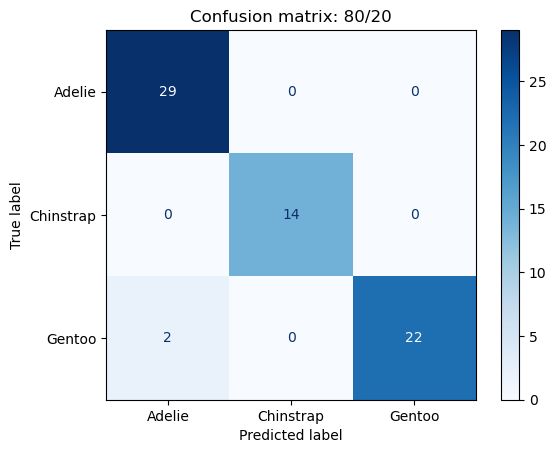

In [ ]:
evaluate_decision_tree_classifier(models['80/20'],'80/20')

#### Evaluation and Insights:
**Classification Report**:

-`Adelie`: The model performs well, with a **precision of 0.94** and **recall of 1.00**, resulting in a high **f1-score of 0.97**. With a support of 29 samples, this class is well represented and clearly learned by the model.

- `Chinstrap`: This class performs exceptionally well, with **precision = 1.00** and **recall = 1.00**, yielding an **f1-score = 1.00**. With 14 samples, the model is highly confident and consistent.

- `Gentoo`: The model performs well for this class, achieving **precision = 1.00**, **recall = 0.92**, and **f1-score = 0.96**. With 24 samples, this class is well-represented in the dataset, contributing to the model's strong performance.

- **Accuracy**: The overall accuracy is **0.97**, indicating that the model correctly predicts the class in the majority of cases.

- **Macro Average**: With macro **precision = 0.98**, macro **recall = 0.97**, and **macro f1-score = 0.97**, we see that the model performs well across all classes, treating each class equally regardless of size.

- **Weighted Average**: The **weighted precision**, **recall**, and **f1-score** are all **0.97**, closely matching accuracy. This shows that the model performs well on average, primarily due to good performance on all classes.

**Confusion Matrix**:
- Most predictions for `Adelie`, `Gentoo`, and `Chinstrap` are correct, showing that the model is highly confident in classifying these classes.
- There are very few false positives for any class, indicating strong precision across all classes.
- Overall, the confusion matrix confirms that the model handles all classes quite well, with minimal misclassifications.


#### d. 90/10 Splitting

,precision,recall,f1-score,support
0,0.88,1.00,0.94,15.00
1,1.00,1.00,1.00,7.00
2,1.00,0.83,0.91,12.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.96,0.94,0.95,34.00
weighted avg,0.95,0.94,0.94,34.00


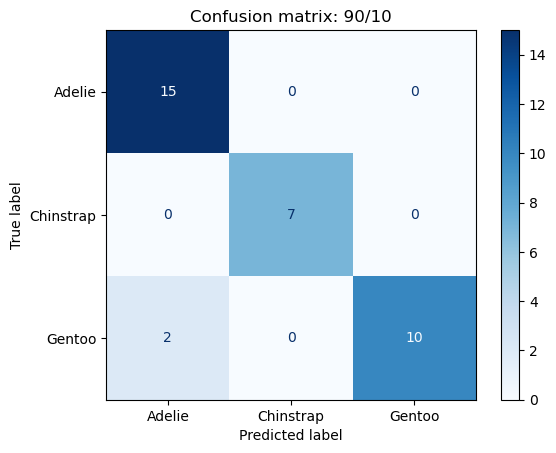

In [19]:
evaluate_decision_tree_classifier(models['90/10'],'90/10')

#### Evaluation and insights:
**Classification Report:**

- `Adelie`: The model performs well, with a **precision of 0.88** and **recall of 1.00**, resulting in a high **f1-score of 0.94**. With a support of 15 samples, this class is well represented and clearly learned by the model.

- `Chinstrap`: This class performs exceptionally well, with **precision = 1.00** and **recall = 1.00**, yielding an **f1-score = 1.00**. With 7 samples, the model is highly confident and consistent.

- `Gentoo`: The model performs well for this class, achieving **precision = 1.00**, **recall = 0.83**, and **f1-score = 0.91**. With 12 samples, this class is well-represented in the dataset, contributing to the model's strong performance.

- **Accuracy**: The overall accuracy is **0.94**, indicating that the model correctly predicts the class in the majority of cases.

- **Macro Average**: With **macro precision = 0.96**, **macro recall = 0.94**, and **macro f1-score = 0.95**, we see that the model performs well across all classes, treating each class equally regardless of size.

- **Weighted Average**: The **weighted precision** is **0.95**, The **weighted recall**, **f1-score** are all **0.94**, closely matching accuracy. This shows that the model performs well on average, primarily due to good performance on all classes.

#### e. Overall Insights

### 4. The Depth and Accuracy of A Decision Tree (80/20 Splitting)

In this section, the task focuses on the 80/20 splitting. We are specifying the maximum depth of a decision tree by testing with the following values: `[None, 2, 3, 4, 5, 6, 7]`. For each depth value, the processing procedure will be: providing the decision tree, visualizing using Graphviz, reporting and visualizing the `accuracy_score`.

As the 80/20 dataset was preprocessed above, we will skip this section.

#### a. Preparing
However, we still have to prepare the testing values.

In [20]:
max_depth_values = [None, 2, 3, 4, 5, 6, 7]

(feature_train, feature_test, label_train, label_test) = datasets['80/20']

#### b. Model Training
After preprocessing the data, we apply the `DecisionTreeClassifier` on the dataset with each depth value.

In [21]:
models = {}

for max_depth in max_depth_values:
    depth_label = f"Depth={max_depth if max_depth is not None else 'None'}"

    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    model.fit(feature_train, label_train)

    models[depth_label] = model

#### c. Visualization
The visualization of the resulting decision trees is processed with Graphviz.

In [22]:
graphs = {}

for max_depth, model in models.items():
    dot_data = tree.export_graphviz(model, out_file=None,
                                    filled=True, rounded=True)
    graph = graphviz.Source(dot_data)

    graphs[max_depth] = graph

Depth = None

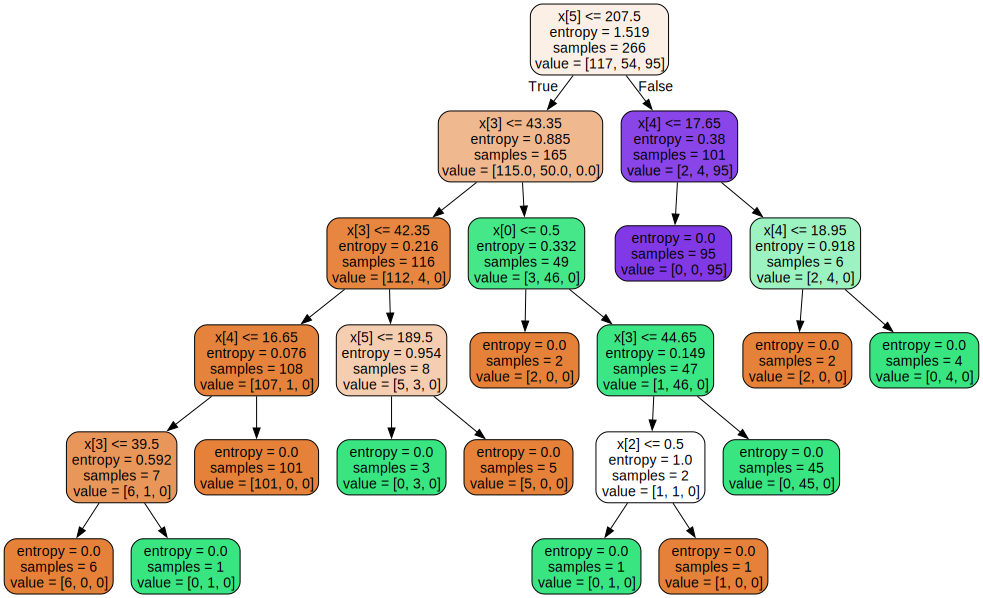

In [23]:
graphs['Depth=None']

Depth = 2

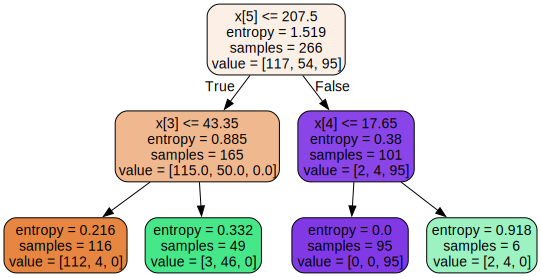

In [24]:
graphs['Depth=2']

Depth = 3

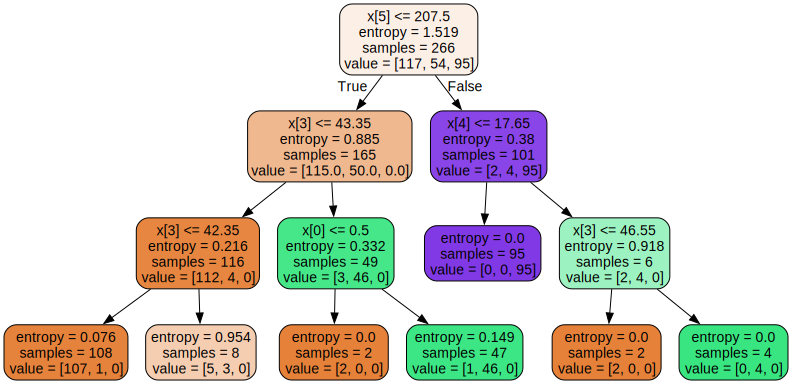

In [25]:
graphs['Depth=3']

Depth = 4

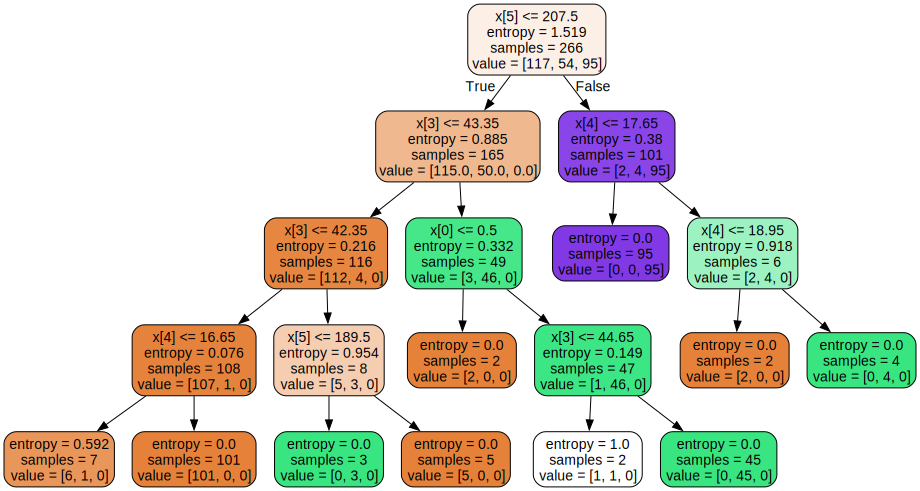

In [26]:
graphs['Depth=4']

Depth = 5

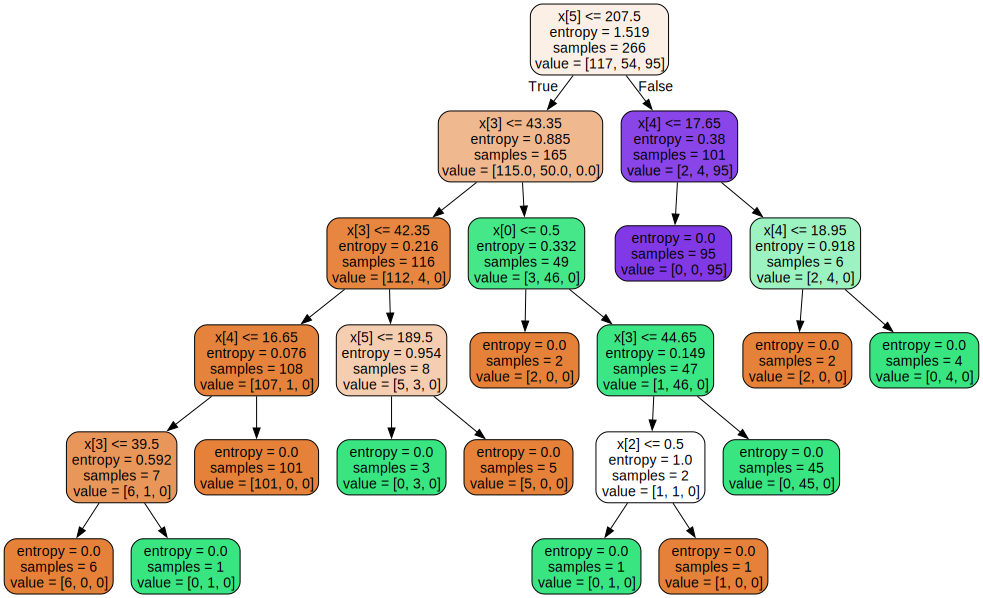

In [27]:
graphs['Depth=5']


Depth = 6

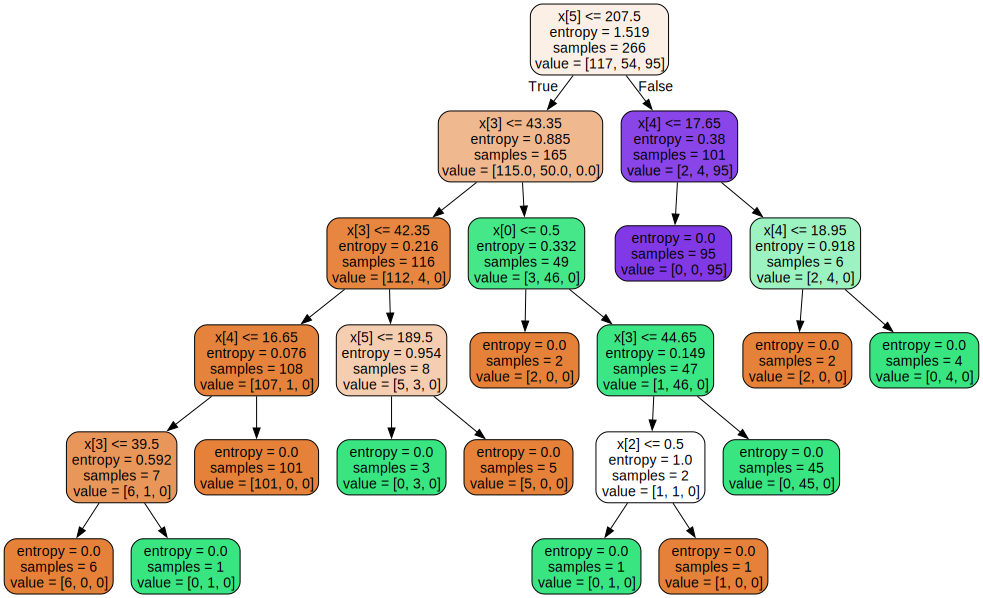

In [28]:
graphs['Depth=6']


Depth = 7

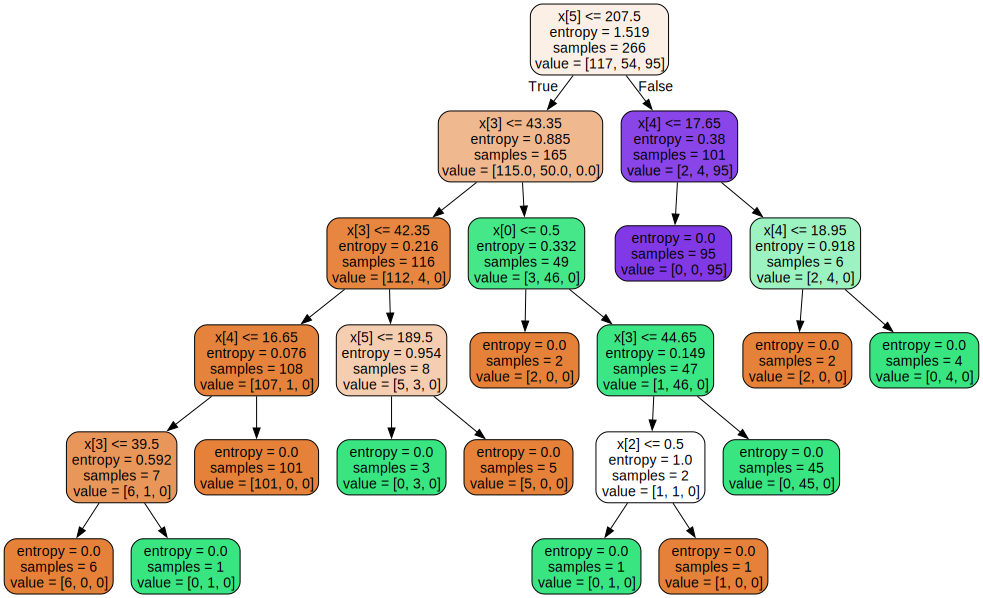

In [29]:
graphs['Depth=6']

#### d. Accuracy Scores

Finally, we will calculate the accuracy scores for each depth value on the test set of the decision tree classifier.

In [30]:
accuracy_scores = {}

for max_depth, model in models.items():
    label_pred = model.predict(feature_test)
    accuracy = accuracy_score(label_test, label_pred)
    accuracy_scores[max_depth] = accuracy

flat_scores = {
    k.replace("Depth=", "").replace("None", "None"): v 
    for k, v in accuracy_scores.items()
}

flat_scores = dict(sorted(
    flat_scores.items(),
    key=lambda x: 1 if x[0] == "None" else int(x[0])
))

accuracy_table = pd.DataFrame([flat_scores], index=["Accuracy"]).round(4)

accuracy_table

,None,2,3,4,5,6,7
Accuracy,0.9701,0.9403,0.9552,0.9701,0.9701,0.9701,0.9701
